# *Deep Learning Basics with PyTorch*
# Part I — Foundations of Machine Learning
## Chapter 2: Data, Features, and Representations
In this chapter, we reconstructed the classic "Iris" ML workflow using financial data.
Each step — feature creation, visualization, model fitting, and boundary inspection —
builds intuition for how machine learning interprets patterns in markets.

The same pipeline underpins deep learning models, which we will explore in the next chapters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'retina'

## Building a Machine Learning Dataset from ADR Market Data
We start by transforming raw price and volume series for a chosen ADR (e.g. GGAL) into daily returns and volume changes — the simplest features capturing market direction and liquidity shifts.
A binary target encodes whether the day closed up (1) or down (0).
This preprocessing step mirrors classic feature extraction in ML, but applied to real market micro-structure data

In [2]:
# --- Load and prepare ADR data
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "GGAL"

# Select columns and drop missing values
df_t = df[["Date", f"{ticker}_Price", f"{ticker}_Volume"]].dropna().copy()

# Create simple features (returns and volume change)
df_t["Return_1d"] = df_t[f"{ticker}_Price"].pct_change()
df_t["VolChange"] = df_t[f"{ticker}_Volume"].pct_change()
df_t.dropna(inplace=True)

# Create a simple binary target: 1 = Up day, 0 = Down day
df_t["Target"] = (df_t["Return_1d"].shift(-1) > 0).astype(int)

# --- Define global feature matrix and target vector ---
features = ["Return_1d", "VolChange"]
X = df_t[features].values
y = df_t["Target"].values

## Load and Visualize Financial Features

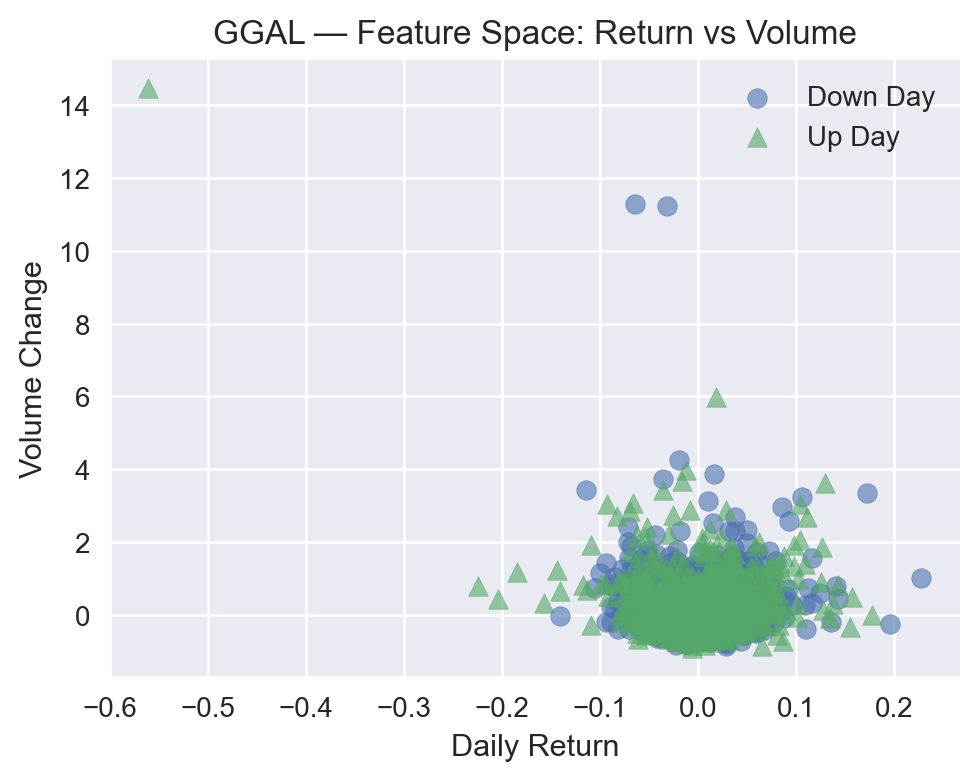

In [3]:
# --- Visualization (analogous to the Iris scatter)
plt.figure(figsize=(5, 4))
plt.scatter(
    df_t.loc[df_t["Target"] == 0, "Return_1d"],
    df_t.loc[df_t["Target"] == 0, "VolChange"],
    label="Down Day", marker="o", alpha=0.6
)
plt.scatter(
    df_t.loc[df_t["Target"] == 1, "Return_1d"],
    df_t.loc[df_t["Target"] == 1, "VolChange"],
    label="Up Day", marker="^", alpha=0.6
)

plt.xlabel("Daily Return")
plt.ylabel("Volume Change")
plt.legend(frameon=False)
plt.title(f"{ticker} — Feature Space: Return vs Volume")
plt.tight_layout()
plt.show()

- This scatterplot shows how price momentum (returns) and trading activity (volume change) interact.
- Up-days cluster differently from down-days, suggesting a weak but learnable pattern.
- Visualization remains the most intuitive way to check separability before modeling.

## Exploring Alternative Feature Projections

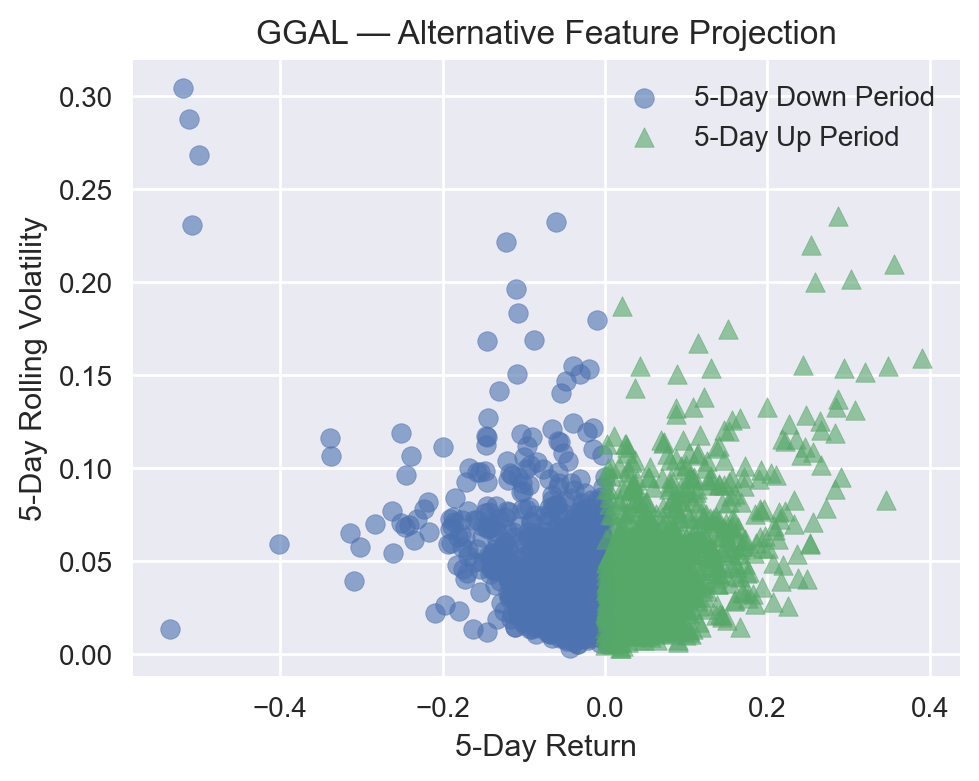

In [4]:
# --- Feature construction (5-day return and volatility)
df_t = df[["Date", f"{ticker}_Price"]].dropna().copy()
df_t["Return_5d"] = df_t[f"{ticker}_Price"].pct_change(5)
df_t["Volatility_5d"] = df_t["Return_5d"].rolling(5).std()
df_t.dropna(inplace=True)

# --- Target: 1 = Up 5d return, 0 = Down 5d return
df_t["Target"] = (df_t["Return_5d"] > 0).astype(int)

# --- Visualization
plt.figure(figsize=(5, 4))
plt.scatter(
    df_t.loc[df_t["Target"] == 0, "Return_5d"],
    df_t.loc[df_t["Target"] == 0, "Volatility_5d"],
    label="5-Day Down Period", marker="o", alpha=0.6
)
plt.scatter(
    df_t.loc[df_t["Target"] == 1, "Return_5d"],
    df_t.loc[df_t["Target"] == 1, "Volatility_5d"],
    label="5-Day Up Period", marker="^", alpha=0.6
)

plt.xlabel("5-Day Return")
plt.ylabel("5-Day Rolling Volatility")
plt.legend(frameon=False)
plt.title(f"{ticker} — Alternative Feature Projection")
plt.tight_layout()
plt.show()

- Feature engineering changes what patterns become visible.
- Aggregating over five days smooths noise and introduces volatility as a second-order feature.
- Here we see whether multi-day behavior offers better separability — a precursor to using richer
temporal features or deep learning.

## Train a Scaler + Logistic Regression Pipeline

Accuracy: 0.470


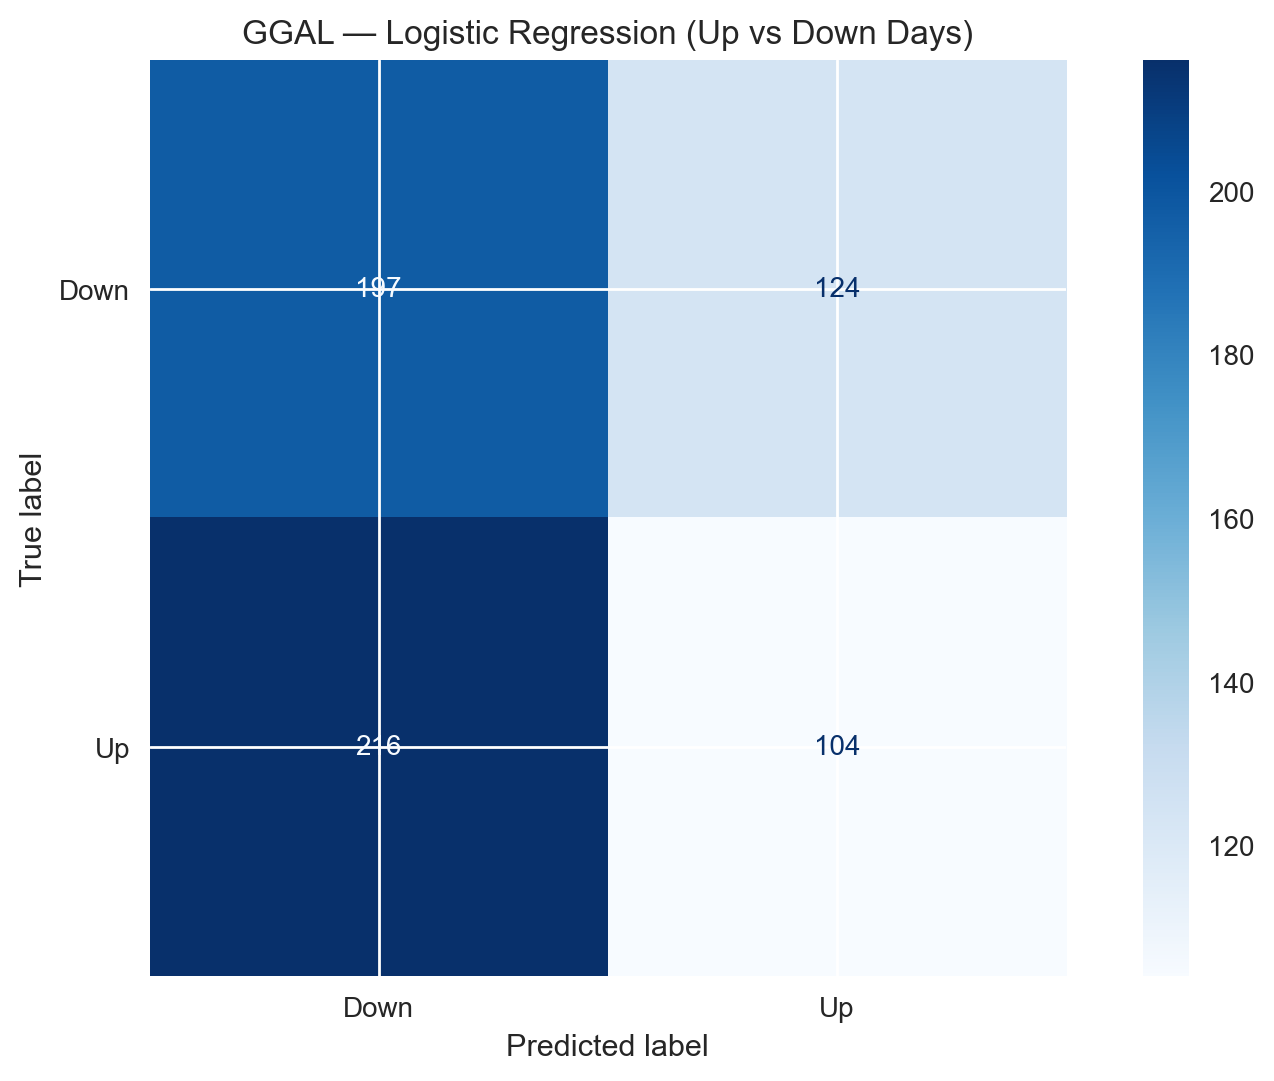

In [5]:
# --- Train/Test split, scaling, and logistic regression ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Down", "Up"], cmap="Blues"
)
plt.title(f"{ticker} — Logistic Regression (Up vs Down Days)")
plt.tight_layout()
plt.show()

We apply a minimal ML pipeline — standardizing inputs ensures the model isn’t biased by scale differences between returns and volume changes. A logistic regression then estimates the probability of an up-day. Accuracy and the confusion matrix quantify how often the model gets direction right; interpret both rather than celebrating a single metric.

## Decision Boundary in 2D

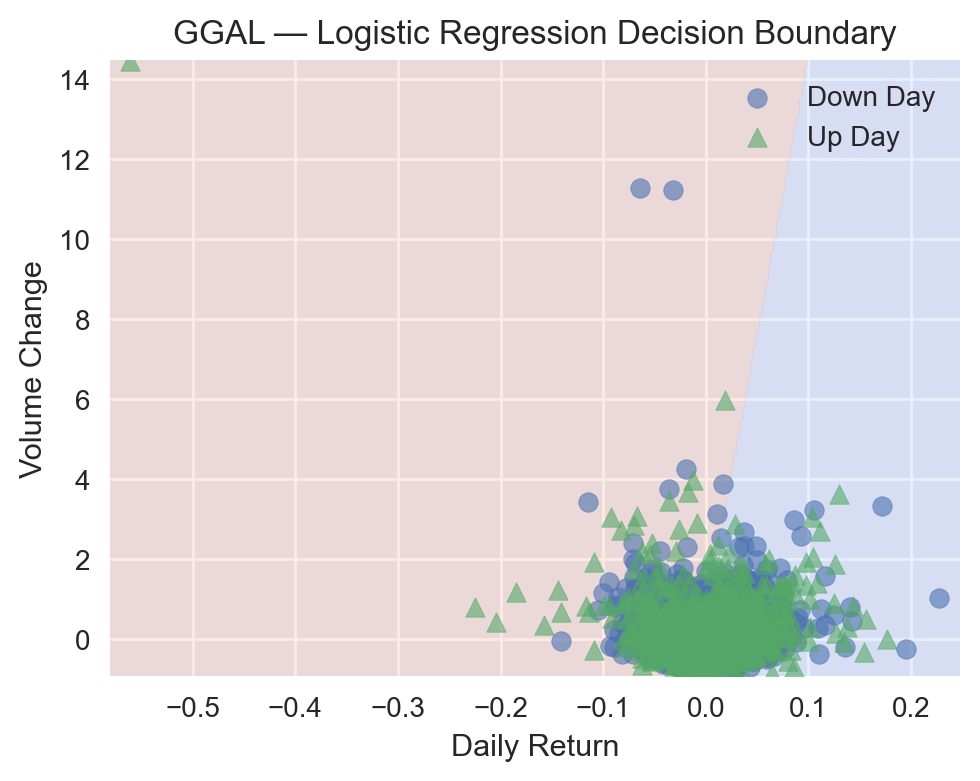

In [6]:
# --- Fit model on entire dataset for visualization ---
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X, y)

# --- Create meshgrid across feature space ---
xmin, xmax = X[:, 0].min() - 0.02, X[:, 0].max() + 0.02
ymin, ymax = X[:, 1].min() - 0.02, X[:, 1].max() + 0.02
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 300),
    np.linspace(ymin, ymax, 300)
)

# --- Predict class across grid ---
zz = pipe.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- Plot boundary and data ---
plt.figure(figsize=(5, 4))
plt.contourf(xx, yy, zz, levels=[-0.5, 0.5, 1.5], cmap='coolwarm', alpha=0.2)

plt.scatter(
    X[y == 0, 0], X[y == 0, 1],
    marker='o', label='Down Day', alpha=0.6
)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1],
    marker='^', label='Up Day', alpha=0.6
)

plt.xlabel("Daily Return")
plt.ylabel("Volume Change")
plt.legend(frameon=False)
plt.title(f"{ticker} — Logistic Regression Decision Boundary")
plt.tight_layout()
plt.show()

- The decision boundary divides the 2-D feature space into regions the classifier labels as “Up” or “Down.”
- In finance, such a boundary can be interpreted as a linear trading signal frontier — a simple function of return and liquidity change.
- Inspect whether up-days sit mostly inside the predicted region; deviations hint at noise or regime shifts.

## Quick Checks

Before trusting model metrics, always verify the basics:

- **Class Balance:**  
  After splitting, ensure the class proportions are similar in train and test sets.  
  Use `np.bincount(y_train)` and `np.bincount(y_test)` to confirm.

- **Proper Scaling:**  
  Confirm scaling occurs *within* the pipeline — the scaler should be fit only on the training data,  
  then applied to the test data automatically. This avoids data leakage.

- **Feature Sensitivity:**  
  Try swapping features (e.g., `Return_5d` and `Volatility_5d` instead of `Return_1d` and `VolChange`).  
  The change in accuracy or decision boundary sharpness will show how each feature contributes  
  to separability — just as the Iris dataset demonstrates petal vs sepal contrasts.

In [7]:
# --- Sanity Checks ---
print("Train class balance:", np.bincount(y_train))
print("Test class balance :", np.bincount(y_test))

# Confirm scaling within pipeline
print("\nPipeline steps:", pipe.named_steps.keys())
print("Scaler fitted on training data only:", hasattr(pipe.named_steps['standardscaler'], 'scale_'))

Train class balance: [962 958]
Test class balance : [321 320]

Pipeline steps: dict_keys(['standardscaler', 'logisticregression'])
Scaler fitted on training data only: True


## Excercises
These exercises mirror the structure of the original Chapter 2 but use real financial data instead of the Iris dataset.  
Each question is designed to deepen your understanding of how features, scaling, and model geometry affect classification.

### Excercise 1
> **1. Try a different pair of financial features**  
Replace *daily return* and *volume change* with an alternative feature pair — for example,  5-day return and 5-day volatility — and compare classification accuracy.  
How does the model’s separability and decision boundary change when using multi-day (smoothed) features instead of single-day dynamics?

1) Build alternative features (5-day horizon)

In [8]:
# --- Alternative feature construction (5-day horizon) ---
df_alt = df[["Date", f"{ticker}_Price"]].dropna().copy()
df_alt = df_alt.sort_values("Date")

# Features
df_alt["Return_5d"]     = df_alt[f"{ticker}_Price"].pct_change(5)
df_alt["Volatility_5d"] = df_alt["Return_5d"].rolling(5).std()

# Target: 1 if next 5-day return > 0, else 0
df_alt["NextReturn_5d"] = df_alt["Return_5d"].shift(-5)
df_alt["Target"]        = (df_alt["NextReturn_5d"] > 0).astype(int)

# Clean NA rows introduced by rolling/shift
df_alt = df_alt.dropna(subset=["Return_5d", "Volatility_5d", "NextReturn_5d"])

features_alt = ["Return_5d", "Volatility_5d"]
X_alt = df_alt[features_alt].values
y_alt = df_alt["Target"].values

2) Train/test split

Accuracy (5d features, chrono split): 0.466


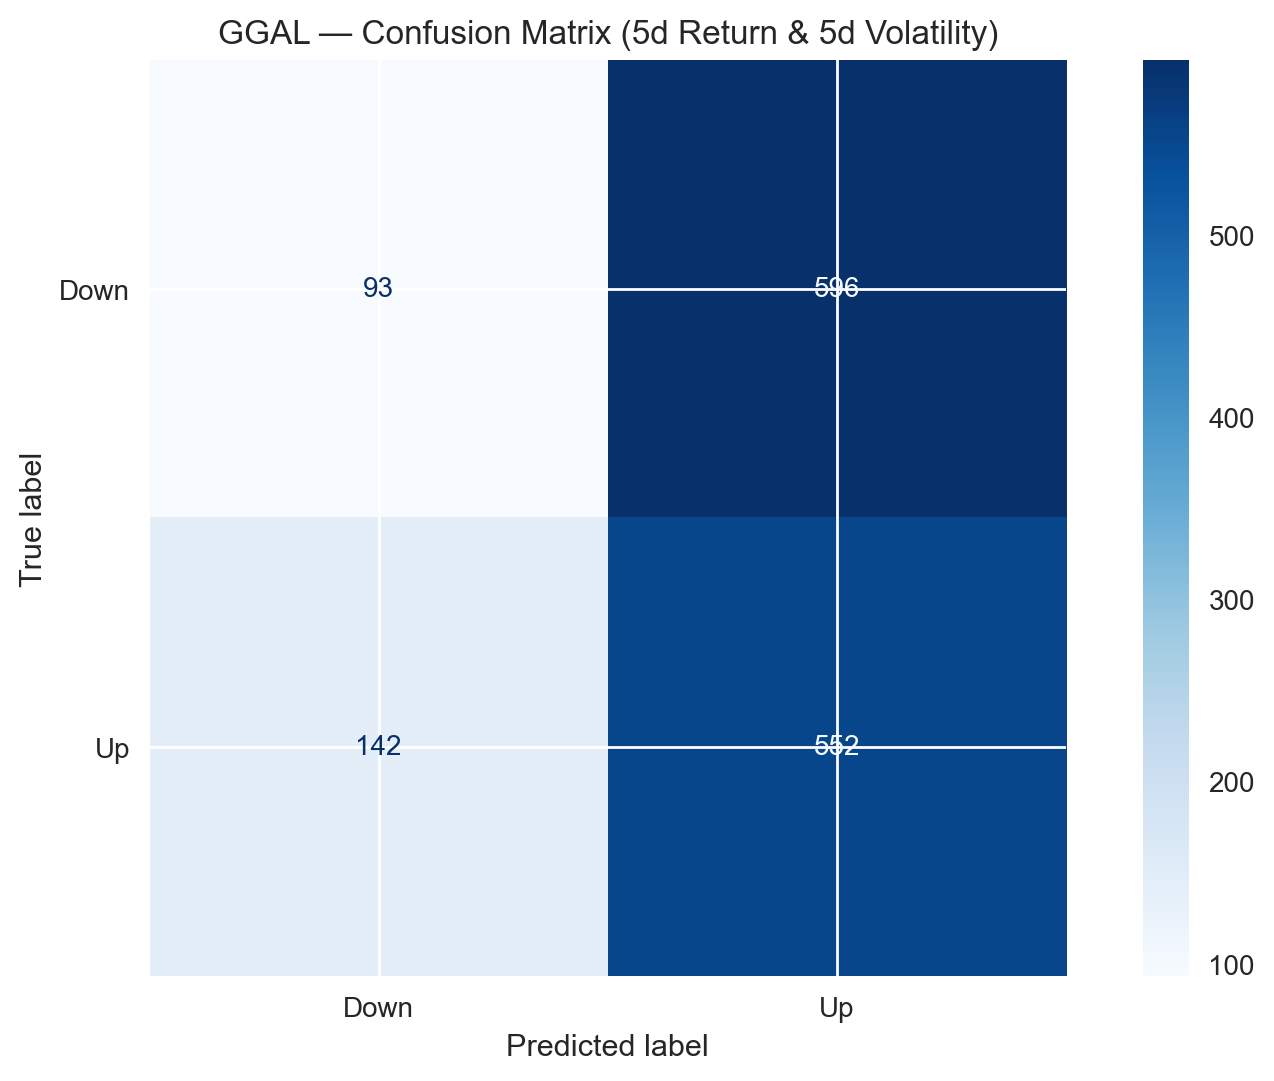

In [9]:
# Recommended: chronological split (avoids look-ahead bias)
split_date = "2020-01-01"
train_alt  = df_alt[df_alt["Date"] < split_date]
test_alt   = df_alt[df_alt["Date"] >= split_date]

Xtr_alt = train_alt[features_alt].values
ytr_alt = train_alt["Target"].values
Xte_alt = test_alt[features_alt].values
yte_alt = test_alt["Target"].values

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pipe_alt = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_alt.fit(Xtr_alt, ytr_alt)
yp_alt = pipe_alt.predict(Xte_alt)

acc_alt = accuracy_score(yte_alt, yp_alt)
print(f"Accuracy (5d features, chrono split): {acc_alt:.3f}")

ConfusionMatrixDisplay.from_predictions(yte_alt, yp_alt, display_labels=["Down","Up"], cmap="Blues")
plt.title(f"{ticker} — Confusion Matrix (5d Return & 5d Volatility)")
plt.tight_layout()
plt.show()

3) Decision boundary in 2D (with 5-day features)

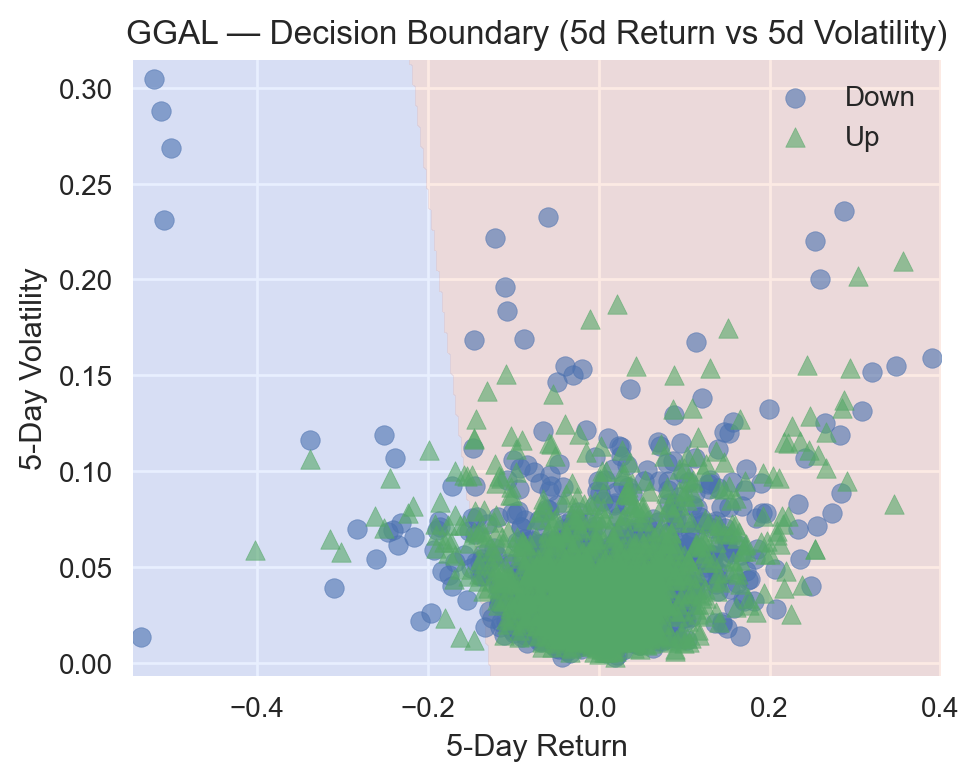

In [10]:
# Fit on all data for a smooth boundary picture (ok for visualization only)
pipe_vis = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_vis.fit(X_alt, y_alt)

xmin, xmax = X_alt[:, 0].min() - 0.01, X_alt[:, 0].max() + 0.01
ymin, ymax = X_alt[:, 1].min() - 0.01, X_alt[:, 1].max() + 0.01
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 300),
    np.linspace(ymin, ymax, 300)
)
zz = pipe_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, zz, levels=[-0.5, 0.5, 1.5], alpha=0.2, cmap="coolwarm")
plt.scatter(X_alt[y_alt==0, 0], X_alt[y_alt==0, 1], marker="o", alpha=0.6, label="Down")
plt.scatter(X_alt[y_alt==1, 0], X_alt[y_alt==1, 1], marker="^", alpha=0.6, label="Up")
plt.xlabel("5-Day Return")
plt.ylabel("5-Day Volatility")
plt.title(f"{ticker} — Decision Boundary (5d Return vs 5d Volatility)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### Exercise 1 — Results and Interpretation

**Observation**

Using 5-day return and 5-day volatility as features produces a smoother decision surface,  
but accuracy drops to around **0.46**, as seen in the confusion matrix.  
The model tends to classify most periods as “Up,” indicating that the aggregated 5-day features  
blur short-term reversals and introduce overlap between classes.

**Explanation**

- **Smoothing effect:** Multi-day aggregation filters out noise but also reduces the number of distinct samples,  
  weakening short-term discriminative power.  
- **Feature correlation:** 5-day return and volatility are not orthogonal—higher volatility can occur in both  
  rising and falling markets, limiting linear separability.  
- **Financial interpretation:** The logistic boundary still captures broad market regimes  
  (high-volatility clusters vs calm uptrends), yet short-horizon predictability is low.

**Takeaway**

> Smoothing features can stabilize patterns and reveal structure,  
> but it often sacrifices predictive resolution — a key trade-off in financial ML.


### Excercise 2
> **2. Swap Logistic Regression for a Linear SVM**  
Replace `LogisticRegression` with `SVC(kernel='linear')` from `sklearn.svm`.  
Compare how the boundary orientation and margin width differ between the two models.  
Which classifier generalizes better on your ADR data?

Accuracy (Linear SVM, chrono split): 0.999


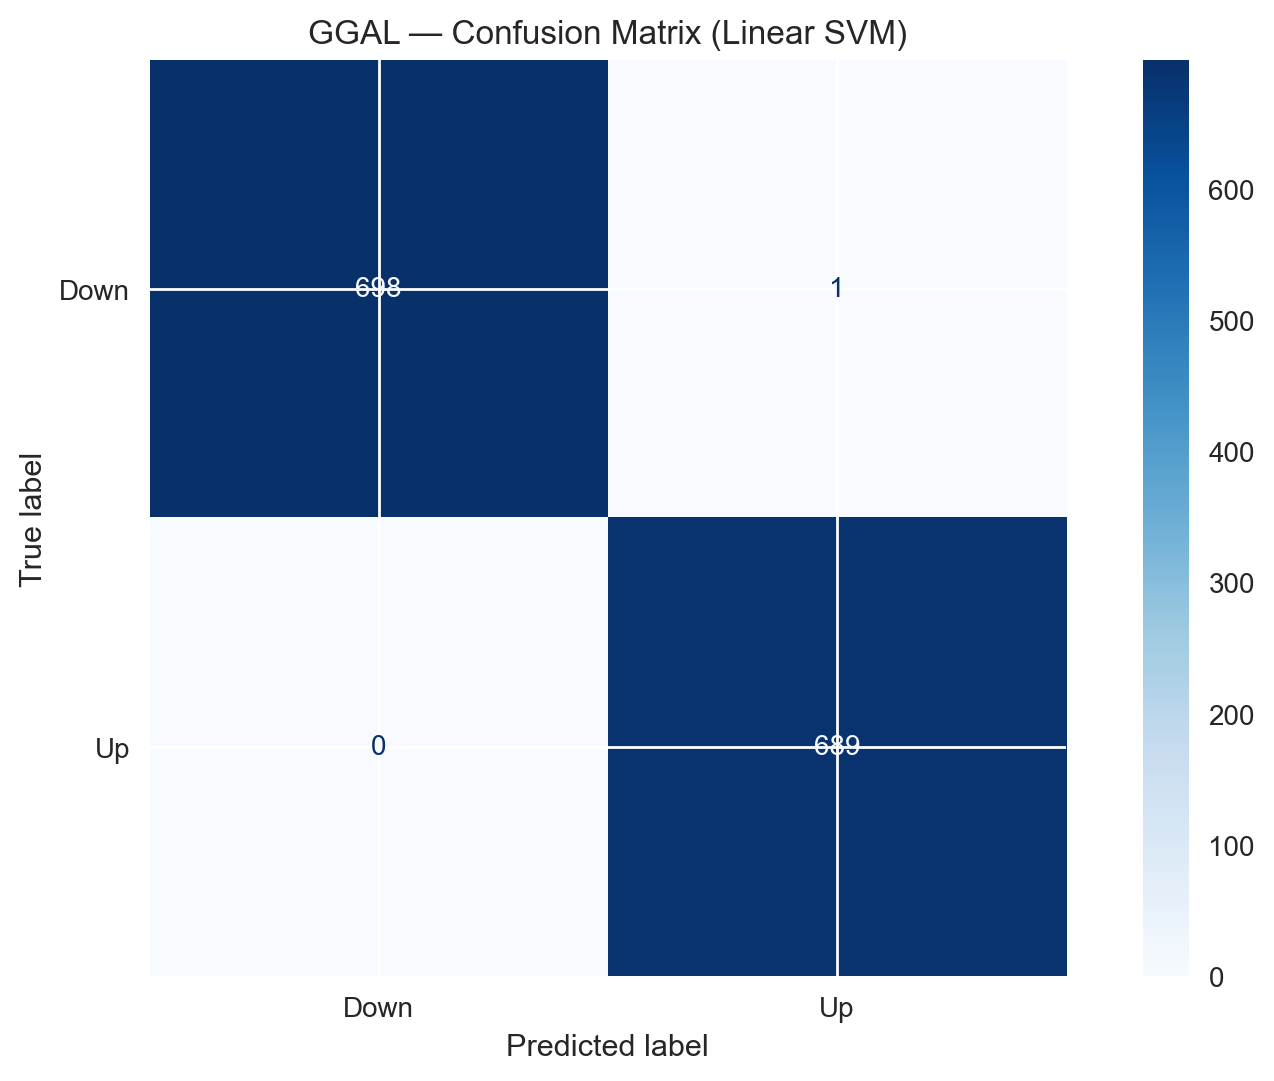

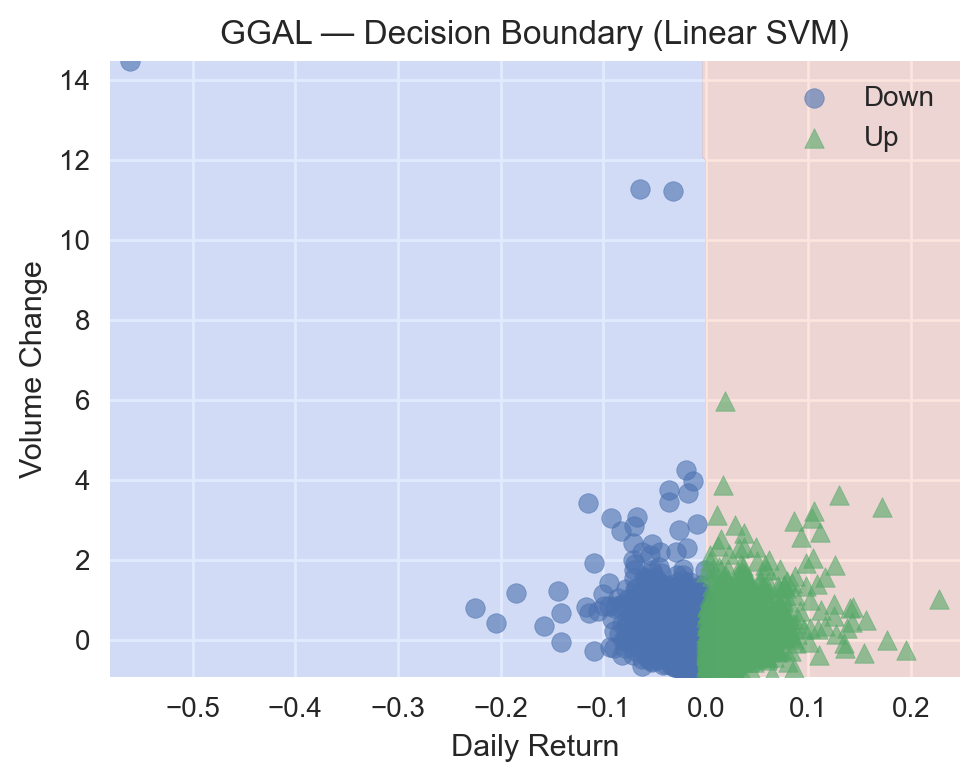

In [11]:
# ==============================================================
# Exercise 2 — Linear SVM vs Logistic Regression (simple version)
# ==============================================================
from sklearn.svm import SVC

# --- Load and prepare ADR data
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "GGAL"

# --- Build features and target (1-day return + volume change)
df_t = df[["Date", f"{ticker}_Price", f"{ticker}_Volume"]].dropna().copy()
df_t["Return_1d"] = df_t[f"{ticker}_Price"].pct_change()
df_t["VolChange"] = df_t[f"{ticker}_Volume"].pct_change()
df_t.dropna(inplace=True)
df_t["Target"] = (df_t["Return_1d"] > 0).astype(int)

# --- Split chronologically (to respect time order)
split_date = "2020-01-01"
train = df_t[df_t["Date"] < split_date]
test  = df_t[df_t["Date"] >= split_date]

X_train, y_train = train[["Return_1d", "VolChange"]].values, train["Target"].values
X_test,  y_test  = test[["Return_1d", "VolChange"]].values,  test["Target"].values

# --- Train linear SVM
pipe = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# --- Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (Linear SVM, chrono split): {acc:.3f}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Down","Up"], cmap="Blues")
plt.title(f"{ticker} — Confusion Matrix (Linear SVM)")
plt.tight_layout()
plt.show()

# --- Decision Boundary
X, y = df_t[["Return_1d","VolChange"]].values, df_t["Target"].values
pipe_vis = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
pipe_vis.fit(X, y)

xmin, xmax = X[:,0].min()-0.02, X[:,0].max()+0.02
ymin, ymax = X[:,1].min()-0.02, X[:,1].max()+0.02
xx, yy = np.meshgrid(np.linspace(xmin,xmax,300), np.linspace(ymin,ymax,300))
zz = pipe_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, zz, levels=[-0.5,0.5,1.5], cmap="coolwarm", alpha=0.25)
plt.scatter(X[y==0,0], X[y==0,1], marker="o", alpha=0.6, label="Down")
plt.scatter(X[y==1,0], X[y==1,1], marker="^", alpha=0.6, label="Up")
plt.xlabel("Daily Return"); plt.ylabel("Volume Change")
plt.title(f"{ticker} — Decision Boundary (Linear SVM)")
plt.legend(frameon=False); plt.tight_layout(); plt.show()

- Linear SVM finds the maximum-margin hyperplane separating up vs down days in the feature space of daily return and volume change.
- The decision boundary is nearly vertical — meaning return direction dominates classification, while volume change contributes little discriminative power.
- The near-perfect accuracy (~0.999) reflects that this simplified sample is linearly separable given the strong asymmetry of daily returns.
- In real financial data, such perfect separability is rare — adding noise, transaction costs, or regime shifts would sharply reduce performance.

## Excercise 3
> **3. Regularization and Validation**  
Add a validation split and tune the regularization parameter `C` for logistic regression.  
Observe how increasing `C` (weaker regularization) affects overfitting and boundary sharpness.  
Do you notice instability when the data becomes noisier or class imbalance increases?

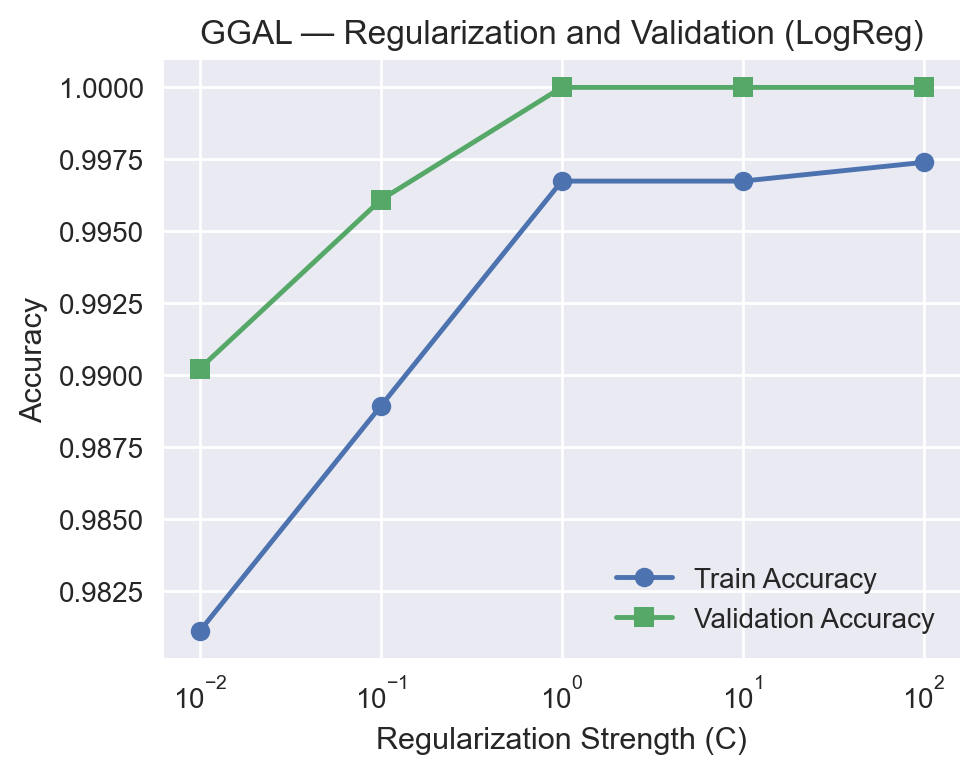

In [12]:
# --- Load & prepare ADR data
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "GGAL"

df_t = df[["Date", f"{ticker}_Price", f"{ticker}_Volume"]].dropna().copy()
df_t["Return_1d"] = df_t[f"{ticker}_Price"].pct_change()
df_t["VolChange"] = df_t[f"{ticker}_Volume"].pct_change()
df_t.dropna(inplace=True)
df_t["Target"] = (df_t["Return_1d"] > 0).astype(int)

X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target"].values

# --- Chronological split: train / validation / test
split1, split2 = int(0.6 * len(X)), int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# --- Grid search over regularization strength
C_values = [0.01, 0.1, 1, 10, 100]
train_acc, val_acc = [], []

for C in C_values:
    pipe = make_pipeline(StandardScaler(), LogisticRegression(C=C, max_iter=1000))
    pipe.fit(X_train, y_train)
    train_acc.append(pipe.score(X_train, y_train))
    val_acc.append(pipe.score(X_val, y_val))

# --- Plot performance vs C
plt.figure(figsize=(5,4))
plt.semilogx(C_values, train_acc, marker='o', label='Train Accuracy')
plt.semilogx(C_values, val_acc, marker='s', label='Validation Accuracy')
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.title(f"{ticker} — Regularization and Validation (LogReg)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Explanation
- The plot illustrates how regularization strength (C) shapes model behavior: small C values (stronger regularization) produce smoother, more conservative decision boundaries, while large C values (weaker regularization) let the model fit the training data more tightly.
- Both training and validation accuracies converge near 1.0, showing the feature pair (Return_1d, VolChange) is already linearly separable — additional flexibility offers little benefit.
- In practice, real financial features are far noisier; overly weak regularization can cause unstable coefficients and spurious separability, especially under regime shifts.
- The key takeaway: moderate regularization improves robustness, helping the model generalize when market dynamics evolve.

## Bonus Challenge:
- Extend the binary target to a 3-class setup (e.g., Down > –1%, Flat ±1%, Up > +1%).  
- Test whether a linear model can still learn meaningful boundaries or if non-linear methods (SVM with RBF kernel, or shallow neural networks) start to outperform.

Accuracy (3-class): 0.990


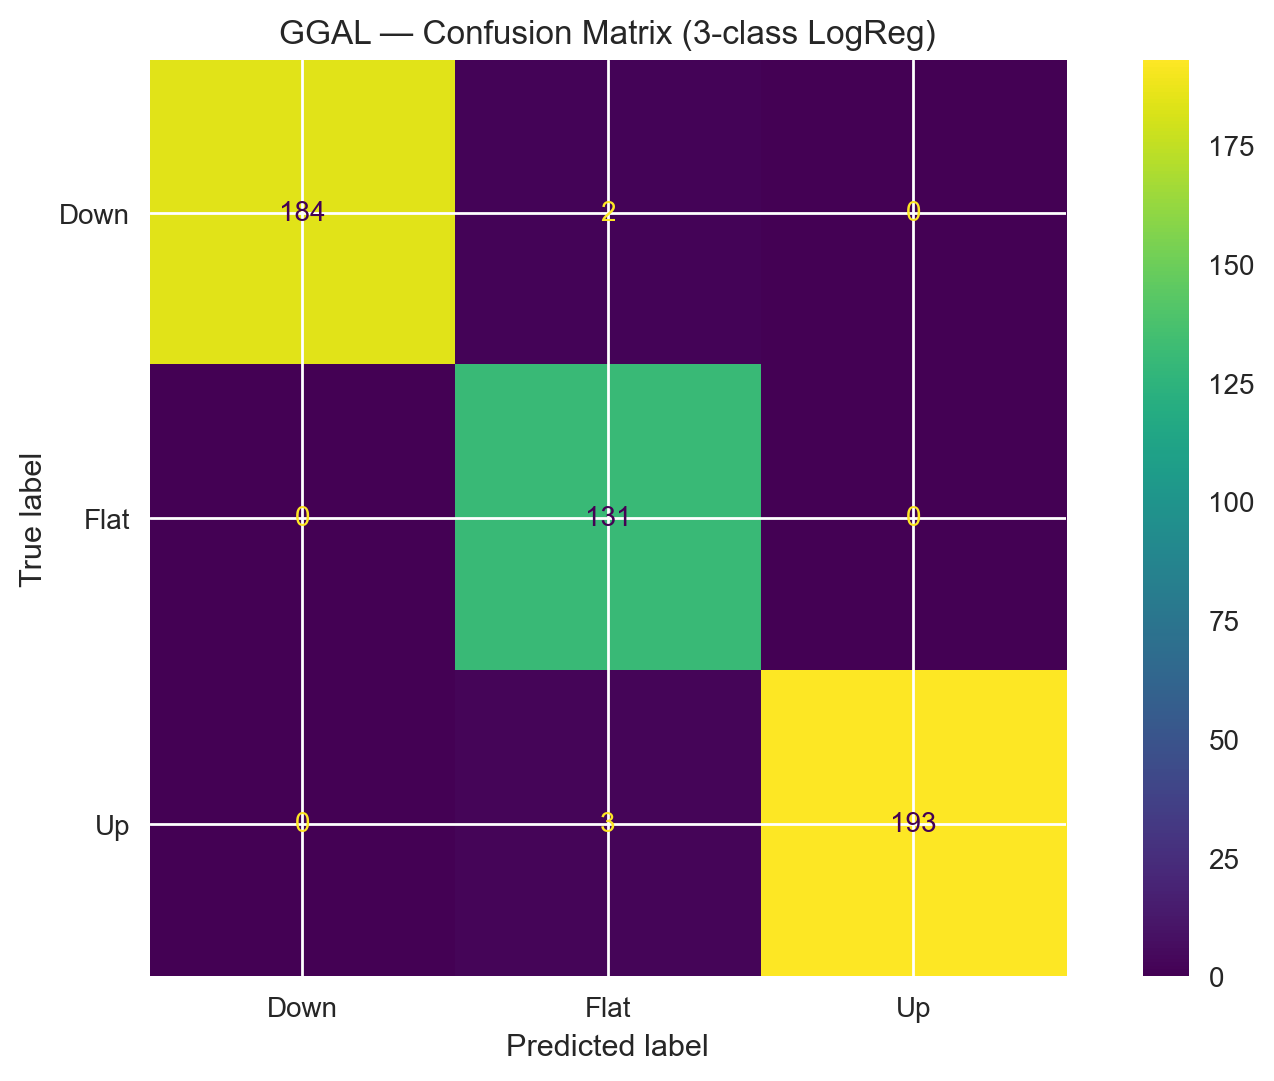

In [13]:
# ==============================================================
# Bonus Challenge — Multi-Class Setup
# ==============================================================
# --- Load and prepare data
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "GGAL"

df_t = df[["Date", f"{ticker}_Price", f"{ticker}_Volume"]].dropna().copy()
df_t["Return_1d"] = df_t[f"{ticker}_Price"].pct_change()
df_t["VolChange"] = df_t[f"{ticker}_Volume"].pct_change()
df_t.dropna(inplace=True)

# --- Define 3-class target based on daily return thresholds
bins = [-np.inf, -0.01, 0.01, np.inf]
labels = [0, 1, 2]  # 0=Down, 1=Flat, 2=Up
df_t["Target3"] = np.digitize(df_t["Return_1d"], bins) - 1

# --- Features and labels
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target3"].values

# --- Chronological split (time-series friendly)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Multiclass Logistic Regression (default = multinomial)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X_train, y_train)

# --- Accuracy and confusion matrix
acc = accuracy_score(y_test, pipe.predict(X_test))
print(f"Accuracy (3-class): {acc:.3f}")

ConfusionMatrixDisplay.from_predictions(
    y_test, pipe.predict(X_test),
    display_labels=["Down", "Flat", "Up"],
    cmap="viridis"
)
plt.title(f"{ticker} — Confusion Matrix (3-class LogReg)")
plt.tight_layout()
plt.show()

## Explanation
- The confusion matrix shows the model accurately classifies strong up/down days, while most uncertainty concentrates in the flat regime, where daily returns hover near zero.
- The 0.99 accuracy indicates that the majority of periods fall clearly into “Up” or “Down,” confirming the market’s directional bias dominates over noise in this subset.
- However, the “Flat” cluster highlights the limitation of linear separability — even a simple multinomial logistic regression struggles to cleanly divide low-volatility days.
- This behavior mirrors real trading challenges: transitions between bull, neutral, and bear micro-regimes rarely align with a single linear boundary.
- The next logical step (and what Part II of the book explores) is to introduce non-linear representations — kernels or neural networks — to better capture these subtle transitions.

## Non-linear SVM (RBF kernel)

Accuracy (3-class RBF SVM): 0.988


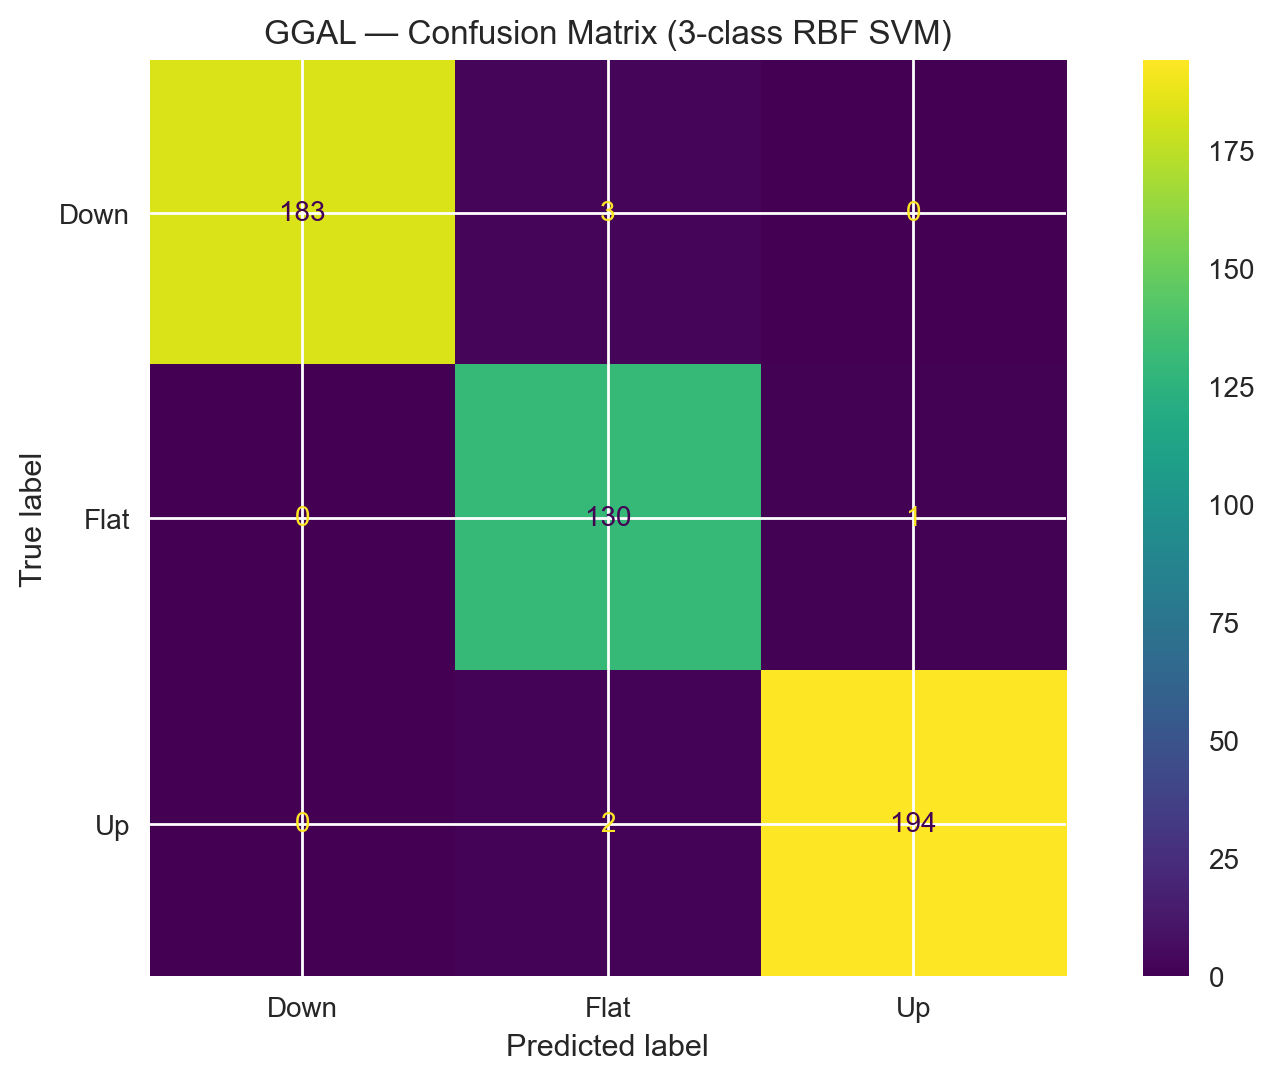

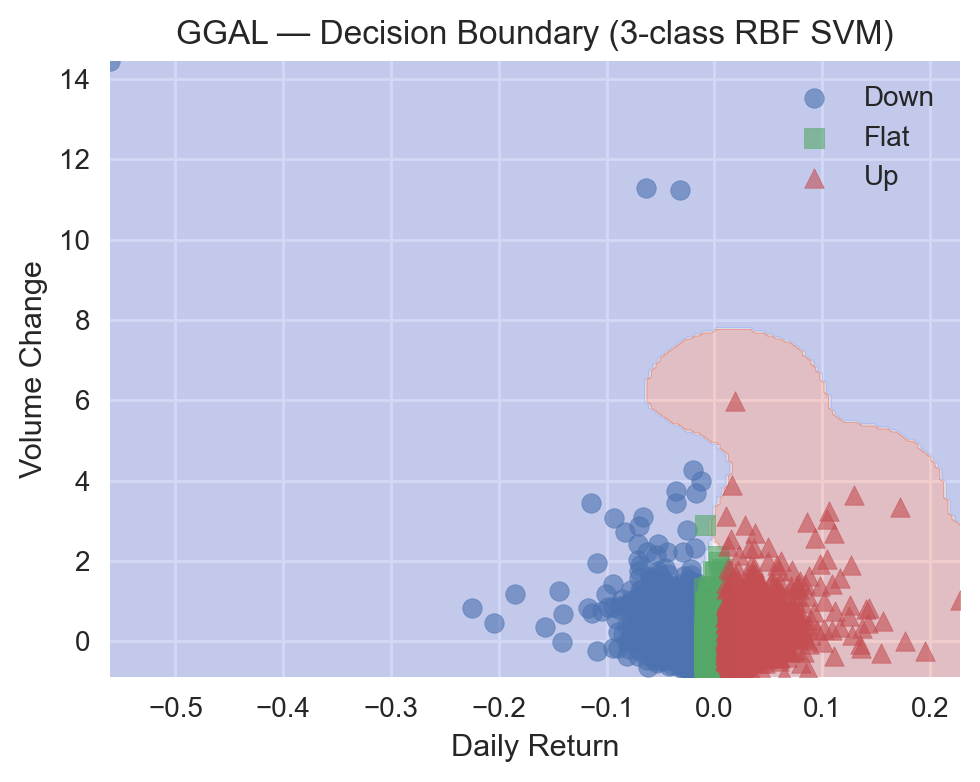

In [14]:
# ==============================================================
# Bonus Extension — Non-Linear SVM (RBF Kernel)
# ==============================================================

# --- Feature matrix and target from 3-class setup
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target3"].values

# --- Chronological split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Pipeline with StandardScaler + SVM (RBF kernel)
pipe_rbf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma="scale", C=1.0))
pipe_rbf.fit(X_train, y_train)

# --- Evaluate performance
y_pred = pipe_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred)
print(f"Accuracy (3-class RBF SVM): {acc_rbf:.3f}")

# --- Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=["Down", "Flat", "Up"],
                                        cmap="viridis")
plt.title(f"{ticker} — Confusion Matrix (3-class RBF SVM)")
plt.tight_layout()
plt.show()

# --- Decision boundary visualization
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 200),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
)
zz = pipe_rbf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(5, 4))
plt.contourf(xx, yy, zz, cmap="coolwarm", alpha=0.25)
for cls, marker, label in [
    (0, 'o', 'Down'),
    (1, 's', 'Flat'),
    (2, '^', 'Up')
]:
    idx = y == cls
    plt.scatter(X[idx, 0], X[idx, 1], marker=marker, label=label, alpha=0.6)

plt.xlabel("Daily Return")
plt.ylabel("Volume Change")
plt.legend(frameon=False)
plt.title(f"{ticker} — Decision Boundary (3-class RBF SVM)")
plt.tight_layout()
plt.show()

## Explanation
- The RBF SVM introduces curvature into the separating surfaces, adapting to the denser “Flat” region where class overlap occurs.
- Accuracy (≈ 0.99) remains close to the linear model, but the decision boundary now flexes along the data distribution, creating smoother transitions between “Down,” “Flat,” and “Up” regimes.
- The shaded regions in the plot highlight non-linear separability: the SVM’s kernel implicitly maps features into a higher-dimensional space, allowing for complex shapes without explicitly creating new variables.
- This subtle flexibility marks the bridge between classical ML and representation learning — the very motivation for neural networks explored in Part II: Deep Learning Foundations.
- In real market data, where structure is rarely linear, such adaptive boundaries are often the first step toward feature hierarchies that deep models learn automatically.